In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow.keras.models     import Model
from tensorflow.keras.layers     import Input, Dense, Dropout, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ---------- hyperparameters ----------
EPOCHS       = 30
BATCH_SIZE   = 64
LATENT_SPACE = 64

tf.random.set_seed(2)

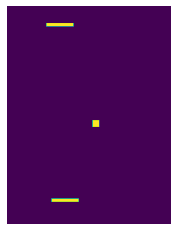

In [3]:
# ---------- training data ----------
screens = np.load('_screens.npy')
screens = screens.reshape( (-1, 256, 192, 1) )
screens = screens.astype(np.float32)

plt.axis('off')
plt.imshow(screens[0].reshape(256, 192))
plt.show()

## Create the models

In [4]:
# encoder
i = Input( shape=(256, 192, 1) )

x = Conv2D( filters=8, kernel_size=4, strides=2, padding='same')(i)
x = LeakyReLU()(x)

x = Conv2D( filters=16, kernel_size=4 , strides=2, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D( filters=16, kernel_size=4 , strides=2, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D( filters=32, kernel_size=4 , strides=2, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D( filters=64, kernel_size=4 , strides=2, padding='same')(x)
x = LeakyReLU()(x)

x = Flatten()(x)

x = Dense( LATENT_SPACE, activation='sigmoid' )(x)

encoder = Model(i, x)
print(encoder.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 192, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 96, 8)        136       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 96, 8)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 48, 16)        2064      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 24, 16)        4112      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 24, 16)        0     

In [5]:
# decoder
i = Input( shape=(LATENT_SPACE) )

x = Dense( 6144 )(i)
x = LeakyReLU()(x)

x = Reshape( target_shape=(16, 12, 32) )(x)

x = Conv2DTranspose( 32, kernel_size=4, strides=2, padding='same' )(x)
x = LeakyReLU()(x)

x = Conv2DTranspose( 16, kernel_size=8, strides=2, padding='same' )(x)
x = LeakyReLU()(x)

x = Conv2DTranspose( 8, kernel_size=8, strides=2, padding='same' )(x)
x = LeakyReLU()(x)

x = Conv2DTranspose( 1 , kernel_size=32, strides=2, padding='same', activation='sigmoid' )(x)

decoder = Model(i, x)
print(decoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6144)              399360    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 6144)              0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 12, 32)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 24, 32)        16416     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 24, 32)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 48, 16)        3278

In [6]:
i = Input( shape=(256, 192, 1) )
x = encoder(i)
x = decoder(x)

autoencoder = Model(i, x)
autoencoder.compile( loss='binary_crossentropy', optimizer=RMSprop(lr=0.0005) )
print(autoencoder.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 192, 1)]     0         
_________________________________________________________________
model (Model)                (None, 64)                244040    
_________________________________________________________________
model_1 (Model)              (None, 256, 192, 1)       464953    
Total params: 708,993
Trainable params: 708,993
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [7]:
# ---------- training loop ----------
history = autoencoder.fit( x=screens, y=screens, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.1 )
history = history.history

Train on 18001 samples, validate on 2001 samples
Epoch 1/30
18001/18001 [==============================] - 43s 2ms/sample - loss: 0.0396 - val_loss: 0.0119
Epoch 2/30
18001/18001 [==============================] - 26s 1ms/sample - loss: 0.0077 - val_loss: 0.0057
Epoch 3/30
18001/18001 [==============================] - 26s 1ms/sample - loss: 0.0045 - val_loss: 0.0039
Epoch 4/30
18001/18001 [==============================] - 26s 1ms/sample - loss: 0.0032 - val_loss: 0.0035
Epoch 5/30
18001/18001 [==============================] - 26s 1ms/sample - loss: 0.0026 - val_loss: 0.0022
Epoch 6/30
18001/18001 [==============================] - 26s 1ms/sample - loss: 0.0022 - val_loss: 0.0021
Epoch 7/30
18001/18001 [==============================] - 26s 1ms/sample - loss: 0.0019 - val_loss: 0.0022
Epoch 8/30
18001/18001 [==============================] - 26s 1ms/sample - loss: 0.0017 - val_loss: 0.0014
Epoch 9/30
18001/18001 [==============================] - 26s 1ms/sample - loss: 0.0015 - val_l

## Error Visualization

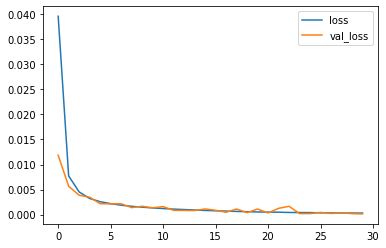

In [8]:
# plot model loss over time
plt.plot(history['loss']        , label='loss')
plt.plot(history['val_loss']    , label='val_loss')

plt.legend(loc=1)
plt.show()

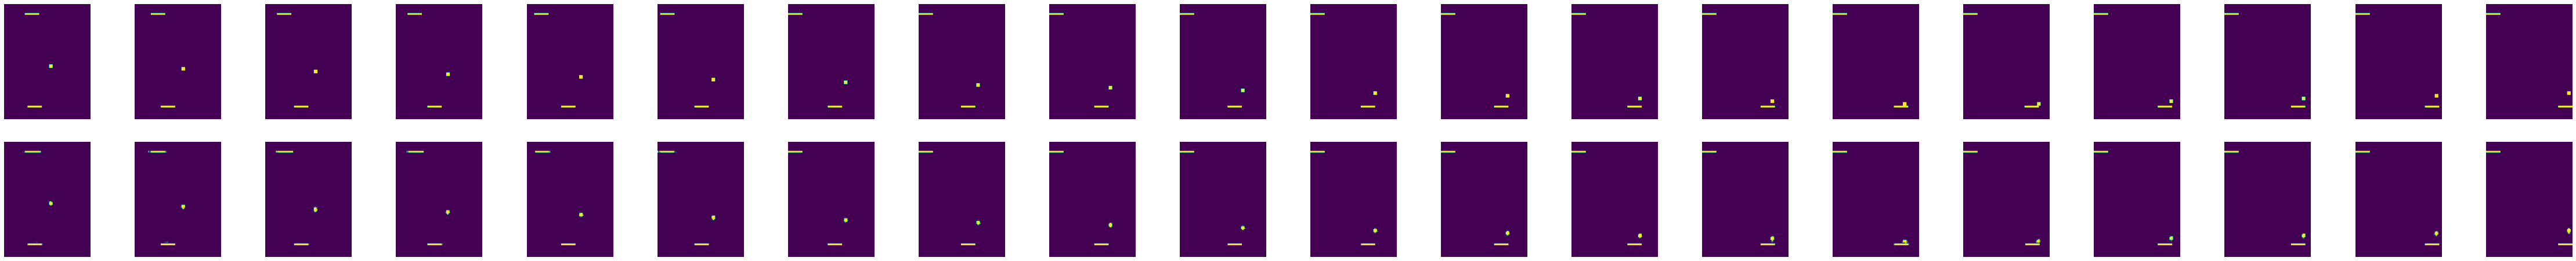

In [9]:
originals   = np.reshape(screens[:20]                     , (20, 256, 192))
predictions = np.reshape(autoencoder.predict(screens[:20]), (20, 256, 192))

# combine the predicted and original arrays
images = np.concatenate((originals, predictions))

# Create a figure from the predicted and real images
cols, rows = 20, 2

fig=plt.figure(figsize=(80, 8))

for i in range(1, cols*rows +1):
    fig.add_subplot(rows, cols, i)
    plt.axis('off')
    plt.imshow(images[i-1])

# Save the figure to the images dir
plt.show()

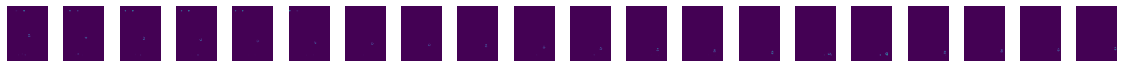

In [10]:
# differences between reconstructed & original images
differences = np.absolute(np.subtract(originals, predictions))

# Create a figure from these differences
cols, rows = 20, 1

fig=plt.figure(figsize=(20, 1))

for i in range(1, cols*rows + 1):
    fig.add_subplot(rows, cols, i)
    plt.axis('off')
    plt.imshow(differences[i-1])

# Save the figure to the images dir
plt.show()

## Save the model locally

In [11]:
encoder.save('models\encoder.h5')
decoder.save('models\decoder.h5')